# 07 Model 2 - Random Forest

# Contents

1. Introduction
2. Define pipeline
3. Baseline model accuracy - Train set
4. Coarse analysis
5. Using this to guide tuning
6. Accuracy after hyperparameter optimisation
7. Model evaluation
8. Conclusion and next steps

First, importing necessary libraries:

In [32]:
import time
import pandas as pd          
import numpy as np         
import matplotlib.pyplot as plt  
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

Importing any necessary machine learning libraries:

# 1. Introduction

In the previous model, we used a single Decision Tree, which gave us 90% test accuracy. While this is a strong result, single decision trees can be prone to overfitting and high variance, meaning they might struggle to generalise to new data. We can see this from the confusion matrix of the Decision Tree model, that this translates to lower classification accuracy, where precision is lower than we would like it to be.

To address these limitations and further improve classification accuracy, we introduce the **Random Forest model.**

* Random Forests improve upon decision trees by using bagging (Bootstrap Aggregating), which trains multiple decision trees on different subsets of the training data and averages their predictions. 
* This reduces variance and improves generalisation. 
* The goal is to leverage the ensemble approach of Random Forests to boost the model’s performance while maintaining stability across different train-test splits.

In this notebook, we will:

* Perform coarse hyperparameter analysis on key hyperparameters to understand their impact on model performance.
* Optimise the model using RandomizedSearchCV for deeper tuning across multiple hyperparameters.
* Compare the performance of Random Forests to the initial Decision Tree model to evaluate improvements in accuracy.

In [35]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from tempfile import mkdtemp


Again, loading our preprocessed variables:

In [5]:
import joblib

# Load the saved data
X_train_resampled_df = joblib.load('../preprocessed_variables/X_train_resampled_df.pkl')
X_test_scaled_df = joblib.load('../preprocessed_variables/X_test_scaled_df.pkl')
y_train_resampled = joblib.load('../preprocessed_variables/y_train_resampled.pkl')
y_test = joblib.load('../preprocessed_variables/y_test.pkl')

# Verify the loaded data
print(X_train_resampled_df.shape, y_train_resampled.shape)
print(X_test_scaled_df.shape, y_test.shape)


(370990, 325) (370990,)
(88597, 325) (88597,)


The shape of this dataset is as anticipated.

# 2. Define pipeline

As we've seen with our Decision Tree model, whilst dimensionality reduction may be a helpful step, Random Forests calculate feature importance scores based on how much each feature decreases the impurity (e.g., Gini impurity or entropy) across all trees in the forest. Features with higher importance scores are considered more influential for the model's predictions.

This means that Random Forests are suitable for highly dimensional data.

As such, let's set up the Machine Learning pipeline:

In [36]:
# Define the pipeline
cachedir = mkdtemp()
estimators_rf = [
    ('model', RandomForestClassifier(n_jobs=8))  # Random Forest Classifier with parallel processing
]
pipe_rf = Pipeline(estimators_rf, memory=cachedir)

# 3. Baseline model accuracy - Train set

Let's the fit the Random Forest model without any cross validation, or hyperparameter optimisation:

In [37]:
# Fit the pipeline on the training data
pipe_rf.fit(X_train_resampled_df, y_train_resampled)

Pipeline(memory='/var/folders/d8/f47z80nj3835j2cjhqsrtc6r0000gn/T/tmp2ryzzstj',
         steps=[('model', RandomForestClassifier(n_jobs=8))])

Running this baseline decision tree model, without any hyperparameter optimisation, let's evaluate the training accuracy of our initial model:

In [38]:
# Compute training accuracy
baseline_train_accuracy_rf = pipe_rf.score(X_train_resampled_df, y_train_resampled)
print(f"Training Accuracy for baseline Random Classifier Model: {baseline_train_accuracy_rf:.8f}")

Training Accuracy for baseline Random Classifier Model: 0.99999730


A very high training accuracy of nearly 100% ! This is without any optimisation or constraints, suggesting the model learns perfectly from our training set data. This means overfitting - we don't know how this performs on test data - and based on our knowledge of decision trees, this is extremely prone to overfitting.

So let's tune our hyperparameters further before evaluating how this performs on test data.

(Note we will not evaluate on test data at this stage, until after our hyperparameter optimisation to prevent data leakage)

# 4. Coarse analysis

The purpose of coarse analysis in our modelling process is to perform an initial exploration of hyperparameters to understand their impact on model performance. 

By systematically varying key hyperparameters (like max_depth, n_estimators, min_samples_leaf), we aim to identify which ranges of these parameters lead to better model accuracy and generalization. 

This helps:

* Determine which hyperparameters warrant deeper exploration/finetuning through methods like RandomizedSearchCV 

* Avoid Overfitting

During this process, we employ 5-fold cross validation:

* 5-fold cross-validation strikes a good balance between bias and variance. 

* It provides a more reliable estimate of model performance than a single train-test split, averaged to produce a single estimate of the model's performance.

### We're going to explore 2 different hyperparameters in turn, noting that:

1. We don't necessarily want to reduce our train accuracy significantly below our baseline RandomForest model
2. We want to strike a balance between how much we can reduce overfitting, whilst still having a strong train accuracy

## (a) Exploring `n_estimators` (number of trees)

* Increasing the number of trees (n_estimators) in the Random Forest can reduce overfitting by averaging out predictions from different trees, but after a certain point, the returns diminish.

* Due to the computational intensity of the random forest classifier, for now let's focus our coarse analysis on how these two hyperparameters impact our train and cross-validation scores:


Starting analysis for `n_estimators`...

Setting n_estimators to 100.
Performing 5-fold cross-validation and calculating train score...
Iteration for n_estimators=100 completed in 57.57 seconds.
Mean Train Score: 1.0000, Mean CV Score: 0.9521

Setting n_estimators to 200.
Performing 5-fold cross-validation and calculating train score...
Iteration for n_estimators=200 completed in 110.63 seconds.
Mean Train Score: 1.0000, Mean CV Score: 0.9524

Setting n_estimators to 300.
Performing 5-fold cross-validation and calculating train score...
Iteration for n_estimators=300 completed in 162.99 seconds.
Mean Train Score: 1.0000, Mean CV Score: 0.9525

Setting n_estimators to 400.
Performing 5-fold cross-validation and calculating train score...
Iteration for n_estimators=400 completed in 209.21 seconds.
Mean Train Score: 1.0000, Mean CV Score: 0.9526

Setting n_estimators to 500.
Performing 5-fold cross-validation and calculating train score...
Iteration for n_estimators=500 completed in 268.

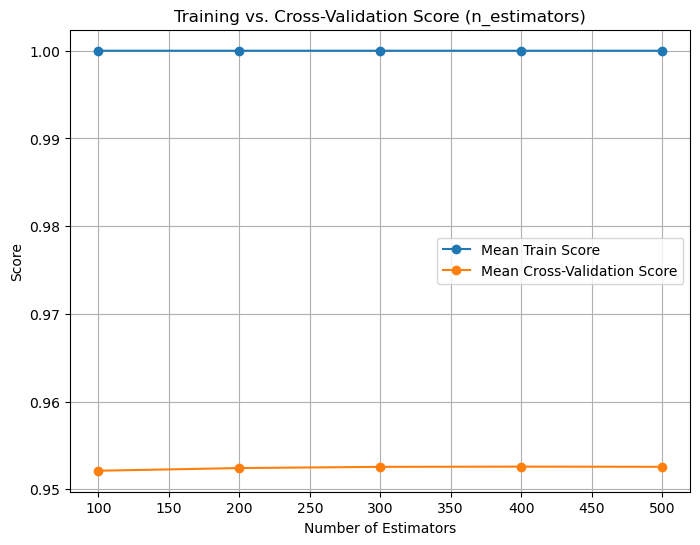

In [39]:
# Define ranges for n_estimators and max_depth
from sklearn.model_selection import cross_validate


n_estimators_range = np.array([100, 200, 300, 400, 500])

train_scores_estimators = []
cv_scores_estimators = []

print("\nStarting analysis for `n_estimators`...")

# Track start time for n_estimators analysis
n_estimators_start_time = time.time()

for n_estimators in n_estimators_range:
    print(f"\nSetting n_estimators to {n_estimators}.")
    iter_start_time = time.time()
    
    # Only set the n_estimators here, since n_jobs=8 is already set in the initialization
    pipe_rf.set_params(model__n_estimators=n_estimators)
    
    # Calculate both train and cross-validation scores using cross_validate
    print("Performing 5-fold cross-validation and calculating train score...")
    scores = cross_validate(pipe_rf, X_train_resampled_df, y_train_resampled, cv=5, 
                            return_train_score=True)
    
    # Extract mean train score and mean cross-validation score
    mean_train_score = np.mean(scores['train_score'])
    mean_cv_score = np.mean(scores['test_score'])
    train_scores_estimators.append(mean_train_score)
    cv_scores_estimators.append(mean_cv_score)
    
    iter_elapsed_time = time.time() - iter_start_time
    print(f"Iteration for n_estimators={n_estimators} completed in {iter_elapsed_time:.2f} seconds.")
    print(f"Mean Train Score: {mean_train_score:.4f}, Mean CV Score: {mean_cv_score:.4f}")

n_estimators_elapsed_time = time.time() - n_estimators_start_time
print(f"\nAnalysis for `n_estimators` completed in {n_estimators_elapsed_time:.2f} seconds.")

# Plotting the training and cross-validation scores for n_estimators
plt.figure(figsize=(8, 6))
plt.plot(n_estimators_range, train_scores_estimators, label="Mean Train Score", marker='o')
plt.plot(n_estimators_range, cv_scores_estimators, label="Mean Cross-Validation Score", marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Training vs. Cross-Validation Score (n_estimators)')
plt.grid(True)
plt.legend()
plt.show()

### Let's get the value for n_estimators with the max cross-validation score:

In [40]:
# Find the index of the maximum cross-validation score
best_index = np.argmax(cv_scores_estimators)

# Get the corresponding n_estimators value
best_n_estimators = n_estimators_range[best_index]

# Print the best n_estimators and the corresponding cross-validation score
print(f"Best n_estimators: {best_n_estimators}")
print(f"Best Cross-Validation Score: {cv_scores_estimators[best_index]:.4f}")

Best n_estimators: 400
Best Cross-Validation Score: 0.9526


This will be very helpful for our tuned model later on, to consider `n_estimators` of around 400.

## (b) Exploring `max_depth`

 This hyperparameter specifies the maximum number of levels (or depth) each individual decision tree in the Random Forest can grow.


Starting analysis for `max_depth`...

Setting max_depth to 10.
Performing 5-fold cross-validation and calculating train score...


/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_


Iteration for max_depth=10 completed in 179.37 seconds.
Mean Train Score: 0.9176, Mean CV Score: 0.9125
Performance on fitted data:
Average Decision Tree Train Score: 0.9689
Random Forest Train Score: 1.0000


Setting max_depth to 15.
Performing 5-fold cross-validation and calculating train score...


/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_


Iteration for max_depth=15 completed in 227.04 seconds.
Mean Train Score: 0.9486, Mean CV Score: 0.9353
Performance on fitted data:
Average Decision Tree Train Score: 0.9689
Random Forest Train Score: 1.0000


Setting max_depth to 20.
Performing 5-fold cross-validation and calculating train score...


/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_


Iteration for max_depth=20 completed in 243.64 seconds.
Mean Train Score: 0.9716, Mean CV Score: 0.9469
Performance on fitted data:
Average Decision Tree Train Score: 0.9689
Random Forest Train Score: 1.0000


Setting max_depth to 25.
Performing 5-fold cross-validation and calculating train score...


/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_


Iteration for max_depth=25 completed in 262.67 seconds.
Mean Train Score: 0.9865, Mean CV Score: 0.9513
Performance on fitted data:
Average Decision Tree Train Score: 0.9689
Random Forest Train Score: 1.0000


Setting max_depth to 30.
Performing 5-fold cross-validation and calculating train score...


/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/nivi_


Iteration for max_depth=30 completed in 285.34 seconds.
Mean Train Score: 0.9951, Mean CV Score: 0.9525
Performance on fitted data:
Average Decision Tree Train Score: 0.9689
Random Forest Train Score: 1.0000


Analysis for `max_depth` completed in 1205.19 seconds.


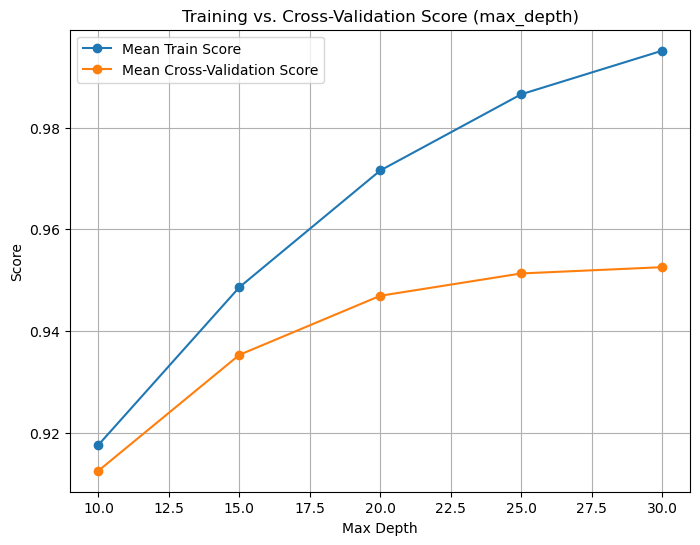

In [42]:
# Range of exploration
max_depth_range = np.array([10, 15, 20, 25, 30])

train_scores_depth = []
cv_scores_depth = []

print("\nStarting analysis for `max_depth`...")

# Track start time for max_depth analysis
max_depth_start_time = time.time()

for max_depth in max_depth_range:
    print(f"\nSetting max_depth to {max_depth}.")
    iter_start_time = time.time()
    
    # Set the max_depth in the pipeline and use n_jobs for parallel processing
    pipe_rf.set_params(model__max_depth=max_depth)
    
    # Calculate both train and cross-validation scores using cross_validate
    print("Performing 5-fold cross-validation and calculating train score...")
    scores = cross_validate(pipe_rf, X_train_resampled_df, y_train_resampled, cv=5, 
                            return_train_score=True, n_jobs=8)  
    
    # Extract mean train score and mean cross-validation score
    mean_train_score = np.mean(scores['train_score'])
    mean_cv_score = np.mean(scores['test_score'])
    train_scores_depth.append(mean_train_score)
    cv_scores_depth.append(mean_cv_score)
    
    # Collect scores for individual decision trees
    decision_tree_train_scores = []
    
    for sub_tree in pipe_rf.named_steps['model'].estimators_:
        decision_tree_train_scores.append(sub_tree.score(X_train_resampled_df, y_train_resampled))

    iter_elapsed_time = time.time() - iter_start_time
    
    print(f"""
Iteration for max_depth={max_depth} completed in {iter_elapsed_time:.2f} seconds.
Mean Train Score: {mean_train_score:.4f}, Mean CV Score: {mean_cv_score:.4f}
Performance on fitted data:
Average Decision Tree Train Score: {np.mean(decision_tree_train_scores):.4f}
Random Forest Train Score: {pipe_rf.score(X_train_resampled_df, y_train_resampled):.4f}
""")

max_depth_elapsed_time = time.time() - max_depth_start_time
print(f"\nAnalysis for `max_depth` completed in {max_depth_elapsed_time:.2f} seconds.")

# Plotting the training and cross-validation scores for max_depth
plt.figure(figsize=(8, 6))
plt.plot(max_depth_range, train_scores_depth, label="Mean Train Score", marker='o')
plt.plot(max_depth_range, cv_scores_depth, label="Mean Cross-Validation Score", marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Training vs. Cross-Validation Score (max_depth)')
plt.grid(True)
plt.legend()
plt.show()


We can see from the plot above that a `max_depth` of 30 has the highest cross-validation score, which is helpful to guide our tuned model.

Based on our coarse analysis, let's tune our hyperparameters and run the model one more time to evaluate accuracy:

# 5. Using coarse analysis and prior modelling efforts to guide tuning

During our hyperparameter tuning process, we initially planned to use `RandomizedSearchCV` to explore a wide range of parameters for our model. However, due to computational limitations, we were unable to complete this approach within a reasonable time frame. Given the intensity of running a full randomized search, we shifted our focus to a coarse analysis, leveraging the insights gained from previous Decision Tree modeling efforts.

This shift in approach was not made lightly; we considered several alternatives to RandomizedSearchCV, ensuring we still captured meaningful results. By relying on prior knowledge and research into hyperparameter optimization for decision trees and related models, we proceeded with guided tuning. For example, based on our earlier Decision Tree experiments and research-backed recommendations (see [this guide to decision tree parameters](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)), we identified key hyperparameters to experiment with as part of our final tuned model.

Informed by the coarse analysis and previous experience, we can narrow down the tuning space to a more manageable size without compromising on performance. For example, as indicated by our earlier results, specific values for `max_depth` (e.g., around 30) and `n_estimators` (e.g., around 400) could lead to improved outcomes. This allows us to run a tuned model, minimising the computational load while still optimising performance.


### Moving ahead, we will set our tuned hyperparameters to address potential overfitting which we saw earlier:

In [43]:
# Define the pipeline
cachedir = mkdtemp()
estimators_rf = [
    # ('rfe', rfe),  # We will omit this for now given the ability of Random Forests/decision trees to deal with highly dimensional data
    ('model', RandomForestClassifier())  # Random Forest Classifier ]
]
pipe_rf = Pipeline(estimators_rf, memory=cachedir)

### In addition to the 2 hyperparameters we explored during coarse analysis, we will include the following in our tuned model:

* `min_samples_split` prevents overfitting requiring a higher number of samples to split an internal node, reducing the depth of the tree and preventing it from learning noise.

* `min_samples_leaf` controls overfitting by ensuring that each leaf node contains a minimum number of samples, preventing the model from learning overly specific patterns in the data.

* `max_features` limits the number of features considered at each split, ensuring that the model doesn't rely too heavily on any one feature and is more generalized.

* `model_bootstrap` True (default) helps prevent overfitting by using bootstrap samples (randomly sampling with replacement) to build different trees, adding variance and reducing the chance of overfitting.

Let's go ahead and fit the model again, this time with tuned hyperparameters to understand the impact on performance:

In [45]:
import time

# Custom callback to print progress
def progress_callback(n_estimators_completed, total_n_estimators):
    print(f"{n_estimators_completed}/{total_n_estimators} trees completed.")

# Fixed hyperparameters based on your coarse analysis
selected_params = {
    'n_estimators': 400,             # Number of trees in the forest
    'max_depth': 30,                 # Maximum depth of the tree
    'min_samples_split': 10,         # Minimum samples required to split an internal node
    'min_samples_leaf': 7,           # Minimum samples required to be at a leaf node
    'max_features': 0.8,             # Number of features to consider when looking for the best split
    'bootstrap': True,                # Whether bootstrap samples are used when building trees
    'n_jobs': 8,                        # Parallel processing with 8 CPU cores
    'verbose': 1                                            
}

pipe_rf.set_params(
    # rfe__n_features_to_select=200,            
    model__n_estimators=selected_params['n_estimators'],
    model__max_depth=selected_params['max_depth'],
    model__min_samples_split=selected_params['min_samples_split'],
    model__min_samples_leaf=selected_params['min_samples_leaf'],
    model__max_features=selected_params['max_features'],
    model__bootstrap=selected_params['bootstrap'],
    model__n_jobs=selected_params['n_jobs'],  # Setting n_jobs for parallel processing
    model__verbose=selected_params['verbose']  # Track progress

)

# Start the timer
start_time = time.time()
print("Starting model fitting with selected hyperparameters...")

# Fit the model (Pipeline) with progress checkpoints
best_model_rf = pipe_rf.fit(X_train_resampled_df, y_train_resampled)

# Add custom progress reporting (for demo purposes, not built into RandomForest by default)
for i in range(0, selected_params['n_estimators'], 50):  # For example, print every 50 trees
    progress_callback(i + 50, selected_params['n_estimators'])

# Calculate total time taken
elapsed_time = time.time() - start_time
print(f"Model fitting completed in {elapsed_time:.2f} seconds.")

# Save the model
joblib.dump(best_model_rf, '../models/best_model_rf.pkl')

# # Evaluate the model on the test data - we'll do this later on in the code
# train_score = best_model_rf.score(X_train_resampled_df, y_train_resampled)
# test_score = best_model_rf.score(X_test_scaled_df, y_test)

# print(f"Train Accuracy: {train_score:.4f}")
# print(f"Test Accuracy: {test_score:.4f}")

# Retrieve the fitted model from the pipeline
best_estimator_rf = best_model_rf.named_steps['model']

# Print final parameters
print(f"Fitted Random Forest Model with parameters: {selected_params}")
print(f'Best Estimator Object: {best_estimator_rf}')


Starting model fitting with selected hyperparameters...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   52.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.1min


50/400 trees completed.
100/400 trees completed.
150/400 trees completed.
200/400 trees completed.
250/400 trees completed.
300/400 trees completed.
350/400 trees completed.
400/400 trees completed.
Model fitting completed in 528.29 seconds.
Fitted Random Forest Model with parameters: {'n_estimators': 400, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 0.8, 'bootstrap': True, 'n_jobs': 8, 'verbose': 1}
Best Estimator Object: RandomForestClassifier(max_depth=30, max_features=0.8, min_samples_leaf=7,
                       min_samples_split=10, n_estimators=400, n_jobs=8,
                       verbose=1)


[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:  8.8min finished


Double check model was saved correctly:

In [47]:
# Verify if the model is fitted
print(hasattr(best_model_rf.named_steps['model'], 'feature_importances_'))  # Should return True if fitted

# If False, it means the model wasn't fitted properly before saving


True


Save other 'best model' results 

In [48]:
best_estimator_rf = best_model_rf.named_steps['model']

In [49]:
# Save the model
joblib.dump(best_estimator_rf, '../models/best_estimator_rf.pkl')


['../models/best_estimator_rf.pkl']

# 6. Accuracy after hyperparameter optimisation

In [3]:
import joblib
best_model_rf = joblib.load('../models/best_model_rf.pkl')

In [7]:
# Compute training accuracy
train_accuracy_rf = best_model_rf.score(X_train_resampled_df, y_train_resampled)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    2.9s finished


In [8]:
print(f"Training Accuracy for Random Forest Model: {train_accuracy_rf:.8f}")

Training Accuracy for Random Forest Model: 0.97264616


In [9]:
# Evaluate the best model on the test data
test_accuracy_rf = best_model_rf.score(X_test_scaled_df, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.7s finished


In [10]:
print(f"Test Accuracy for Random Forest Model: {test_accuracy_rf:.8f}")

Test Accuracy for Random Forest Model: 0.91941036


# 7. Model evaluation

## Looking at train and test accuracy:

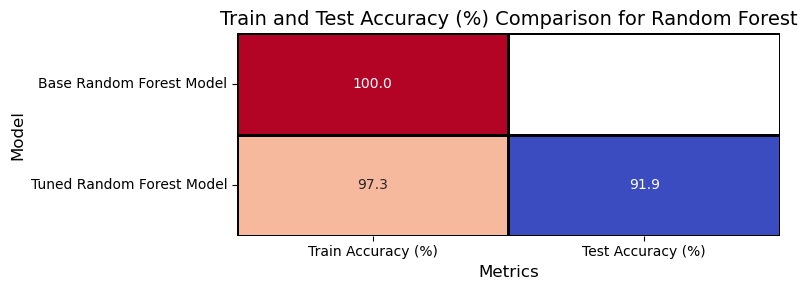

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Random forest accuracy data
accuracy_data_rf = {
    'Train Accuracy (%)': [baseline_train_accuracy_rf * 100, train_accuracy_rf * 100],  # Multiply by 100 to get percentage
    'Test Accuracy (%)': [np.nan, test_accuracy_rf * 100]  # Only the tuned model has test accuracy
}

# Create a DataFrame for random forest accuracy
accuracy_df_rf = pd.DataFrame(accuracy_data_rf, index=['Base Random Forest Model', 'Tuned Random Forest Model'])

# Create a mask for the missing (NaN) values
mask_rf = accuracy_df_rf.isna()

# Plot a heatmap with a mask to hide NaN values
plt.figure(figsize=(8, 3))
sns.heatmap(accuracy_df_rf, annot=True, fmt='.1f', cmap="coolwarm", cbar=False, linewidths=1, linecolor='black', mask=mask_rf)

# Set labels and title
plt.title("Train and Test Accuracy (%) Comparison for Random Forest", fontsize=14)
plt.ylabel("Model", fontsize=12)
plt.xlabel("Metrics", fontsize=12)

plt.tight_layout()
plt.show()


As we saw earlier, we've been able to improve on train and test accuracy observed for our single decision tree model, with slightly higher train and test accuracy.

But how did this translate into classification accuracy?

In [53]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

First, making sure we're making predictions on the test set:

In [54]:
# Make predictions on the test set using the entire pipeline 
y_test_pred_rf = best_model_rf.predict(X_test_scaled_df)


# Saving this
joblib.dump(y_test_pred_rf, '../models/y_test_pred_rf.pkl')


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.7s finished


## Generating the confusion matrix and classification report:

In [55]:
# Confusion matrix and classification report for the test set
conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)
class_report_rf = classification_report(y_test, y_test_pred_rf, output_dict=True)  # Output as a dictionary

## (a) Classification report

In [57]:
class_report_df_rf = pd.DataFrame(class_report_rf).transpose()

# Display the classification report as a table
print(class_report_df_rf)

              precision    recall  f1-score      support
0              0.624920  0.538521  0.578512   9099.00000
1              0.948004  0.963005  0.955446  79498.00000
accuracy       0.919410  0.919410  0.919410      0.91941
macro avg      0.786462  0.750763  0.766979  88597.00000
weighted avg   0.914823  0.919410  0.916734  88597.00000


## Key takeaways, compared to our previous single Decision Tree:

* Precision and Recall for Class 0 (minority class): The Random Forest model performs better than the Decision Tree model, with higher precision (0.62 vs. 0.51) and recall (0.54 vs. 0.50), indicating it is more accurate in predicting the minority class.

* Class 1 (majority class): Both models perform similarly for the majority class ('Highly Satisfied' individuals), though Random Forest slightly outperforms in recall (0.96 vs. 0.94) and F1-Score.


## (b) Confusion matrix

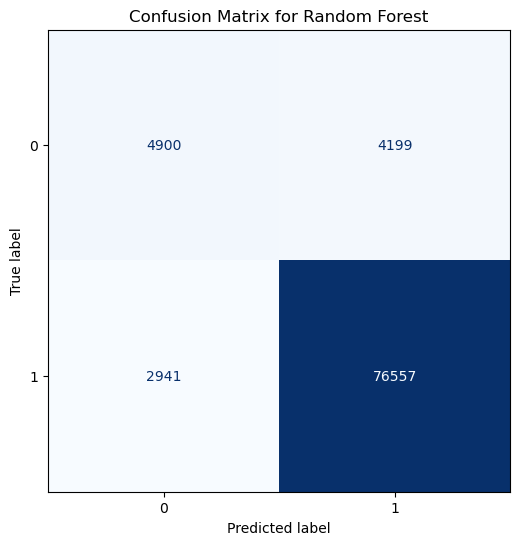

In [56]:
# Display the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(conf_matrix_rf)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title('Confusion Matrix for Random Forest')
plt.grid(False)
plt.show()

### Key takeaways, building on the classification matrix:

The confusion matrix offers a more granular view of how the Random Forest model performed by breaking down the specific outcomes for each class.

* True Negatives (4,900): These are correctly predicted cases for Class 0 (the minority class), which shows that the model can identify some instances of this class, but not all. This partially explains the precision of 0.62 for Class 0 in the classification report, as precision measures the proportion of correct predictions out of all predicted Class 0 cases.

* False Positives (4,199): These are instances where the model incorrectly predicted Class 1 instead of Class 0. The relatively high number of false positives suggests that the model is struggling to separate Class 0 from Class 1. This also contributes to the lower recall of 0.54 for Class 0, meaning that the model misses a substantial portion of the actual Class 0 cases.

* False Negatives (2,941): These are cases where Class 1 (the majority class) was incorrectly predicted as Class 0. Despite this, the number of false negatives is relatively low compared to the true positives, which aligns with the high recall of 0.96 for Class 1 in the classification report, indicating that the model is very good at identifying Class 1.

* True Positives (76,557): These are correctly predicted Class 1 instances, which explain the precision of 0.95 and recall of 0.96 for Class 1. Since the majority of the data belongs to Class 1, this drives up the overall performance metrics, including the high overall accuracy of 91.9%.

Overall:

* Class 0 Performance: The confusion matrix shows that Class 0 has a relatively high number of misclassifications (4199 false positives and 2941 false negatives). This is reflected in the classification report by the lower recall of 0.54 and precision of 0.62 for Class 0. The confusion matrix makes it clear that a significant portion of Class 0 instances are incorrectly classified as Class 1, which brings down the performance metrics for this class.

* Class 1 Dominance: The high number of true positives (76,557) compared to false negatives (2,941) illustrates the model's strength in predicting Class 1 correctly, as seen in the classification report where Class 1 has very high precision and recall. s.

# 8. Conclusion and next steps

The confusion matrix clearly highlights the strength of the Random Forest model in predicting Class 1 (majority class) but also exposes its weakness in predicting Class 0 (minority class). While the model achieves high precision and recall for Class 1, it struggles with Class 0, as seen through the significant number of false positives (4,199) and false negatives (2,941). These misclassifications pull down the recall (0.54) and precision (0.62) for Class 0, which directly influences the lower macro averages in the classification report.

To address the limitations seen in the Random Forest model, we propose the following steps:

* Build and Train a Neural Network: Using the same dataset, we will implement a Neural Network architecture, adjusting for class imbalance using techniques such as class weighting in the loss function. The goal is to ensure better performance for the minority class (Class 0) while maintaining the model's overall performance.

* Monitor Key Metrics: We'll particularly focus on improving recall and precision for Class 0, aiming to reduce false positives and false negatives as seen in the confusion matrix.

* Compare Performance: After training the neural network, we'll compare its confusion matrix and classification report with the Random Forest model to quantify improvements in precision, recall, and overall accuracy.


We explore the implementation of the Neural Network model in more detail in the following notebook: [08 Model 4 - Neural Network](./08%20Model%204%20-%20Neural%20Network.ipynb). This step will help us evaluate whether the neural network can truly address the limitations we've seen in the Random Forest model.